In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df3=pd.read_csv('/content/df_FINAL.csv')

In [3]:
print(df3.shape)

(109541, 42)


In [4]:
from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, f1_score
import matplotlib.pyplot as plt
import numpy as np

In [9]:
X = df3.drop("Status", axis=1)  
y = df3["Status"]  

In [10]:
# Step 1: Data Preprocessing and Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Resampling with ADASYN
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

In [11]:
# Random Forest and RFECV for feature selection
rf_classifier = RandomForestClassifier(random_state=42)
rfecv = RFECV(estimator=rf_classifier, step=1, cv=StratifiedKFold(5),
              scoring='f1', min_features_to_select=1)
rfecv.fit(X_train_resampled, y_train_resampled)

# Get the boolean mask of selected features
selected_features_mask = rfecv.support_
selected_features = X_train_resampled.columns[selected_features_mask]
print("Selected Features:", selected_features)

Selected Features: Index(['Age', 'Education', 'IncomeTotal', 'DebtToIncome', 'AppliedAmount',
       'Amount', 'Interest', 'LoanDuration', 'MonthlyPayment',
       'VerificationType', 'NoOfPreviousLoansBeforeLoan',
       'AmountOfPreviousLoansBeforeLoan', 'PreviousRepaymentsBeforeLoan',
       'ExistingLiabilities', 'LiabilitiesTotal', 'NewCreditCustomer',
       'FreeCash', 'Country_EE', 'Country_ES', 'Country_FI', 'Country_SK',
       'EmploymentDurationCurrentEmployer_MoreThan5Years',
       'EmploymentDurationCurrentEmployer_Other',
       'EmploymentDurationCurrentEmployer_Retiree',
       'EmploymentDurationCurrentEmployer_UpTo1Year',
       'EmploymentDurationCurrentEmployer_UpTo2Years',
       'EmploymentDurationCurrentEmployer_UpTo3Years',
       'EmploymentDurationCurrentEmployer_UpTo4Years',
       'EmploymentDurationCurrentEmployer_UpTo5Years',
       'HomeOwnershipType_Council_house ', 'HomeOwnershipType_Joint_ownership',
       'HomeOwnershipType_Joint_tenant',
       'H

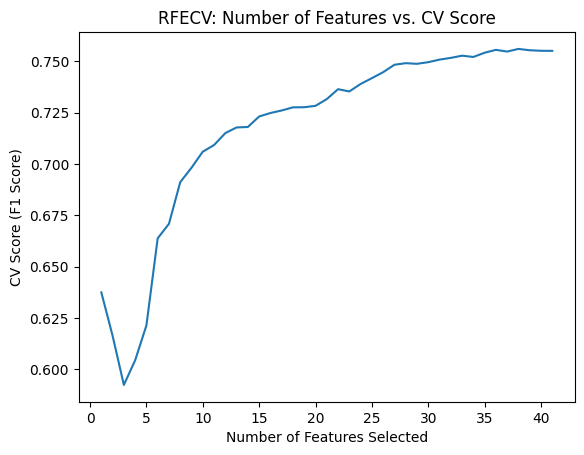

Optimal number of features : 38


In [12]:
#identify a spot where adding more features doesn't significantly improve the performance, which aids in feature reduction and model simplification.
import matplotlib.pyplot as plt

# Check and plot RFECV results
if hasattr(rfecv, 'cv_results_'):
    # Access mean test scores directly from cv_results_
    mean_score = rfecv.cv_results_['mean_test_score']
    plt.figure()
    plt.title("RFECV: Number of Features vs. CV Score")
    plt.xlabel("Number of Features Selected")
    plt.ylabel("CV Score (F1 Score)")
    plt.plot(range(1, len(mean_score) + 1), mean_score)
    plt.savefig('RFECV: NumberOfFeatures vs CV Score.png')
    plt.show()
else:
    # Older versions fallback (not recommended to rely on this)
    print("Update your scikit-learn to use this feature.")

# Printing optimal number of features
print("Optimal number of features : %d" % rfecv.n_features_)

In [14]:
X_train_selected = X_train_resampled[selected_features]

# Initialize and train the Random forest Classifier with only the selected features
final_rf = RandomForestClassifier(verbose=0, random_state=42)
final_rf.fit(X_train_selected, y_train_resampled)

# Get feature importances from the final model
feature_importances = final_rf.feature_importances_

# Map these importances back to the feature names
feature_importance_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance to see the most important features
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the sorted DataFrame to view the importance of each feature
print("Feature Importances for Selected Features:")
print(feature_importance_df)

Feature Importances for Selected Features:
                                             Feature  Importance
2                                        IncomeTotal    0.089596
6                                           Interest    0.087325
0                                                Age    0.083126
8                                     MonthlyPayment    0.075252
14                                  LiabilitiesTotal    0.068538
7                                       LoanDuration    0.054542
5                                             Amount    0.051597
4                                      AppliedAmount    0.048850
12                      PreviousRepaymentsBeforeLoan    0.041401
13                               ExistingLiabilities    0.038964
11                   AmountOfPreviousLoansBeforeLoan    0.036259
1                                          Education    0.034195
3                                       DebtToIncome    0.024466
16                                          Fre

In [15]:
top_features = feature_importance_df.nlargest(38, 'Importance')['Feature'].tolist()

print("Top 38 Features:")
print(top_features)

Top 38 Features:
['IncomeTotal', 'Interest', 'Age', 'MonthlyPayment', 'LiabilitiesTotal', 'LoanDuration', 'Amount', 'AppliedAmount', 'PreviousRepaymentsBeforeLoan', 'ExistingLiabilities', 'AmountOfPreviousLoansBeforeLoan', 'Education', 'DebtToIncome', 'FreeCash', 'HomeOwnershipType_Tenant_pre_furnished_property', 'VerificationType', 'NoOfPreviousLoansBeforeLoan', 'Country_ES', 'HomeOwnershipType_Owner', 'EmploymentDurationCurrentEmployer_MoreThan5Years', 'Country_FI', 'EmploymentDurationCurrentEmployer_UpTo5Years', 'EmploymentDurationCurrentEmployer_UpTo1Year', 'HomeOwnershipType_Living_with_Parents', 'Country_EE', 'HomeOwnershipType_Other', 'HomeOwnershipType_Mortgage', 'EmploymentDurationCurrentEmployer_Retiree', 'EmploymentDurationCurrentEmployer_Other', 'NewCreditCustomer', 'EmploymentDurationCurrentEmployer_UpTo2Years', 'HomeOwnershipType_Tenant_unfurnished_property', 'EmploymentDurationCurrentEmployer_UpTo3Years', 'EmploymentDurationCurrentEmployer_UpTo4Years', 'HomeOwnershipType

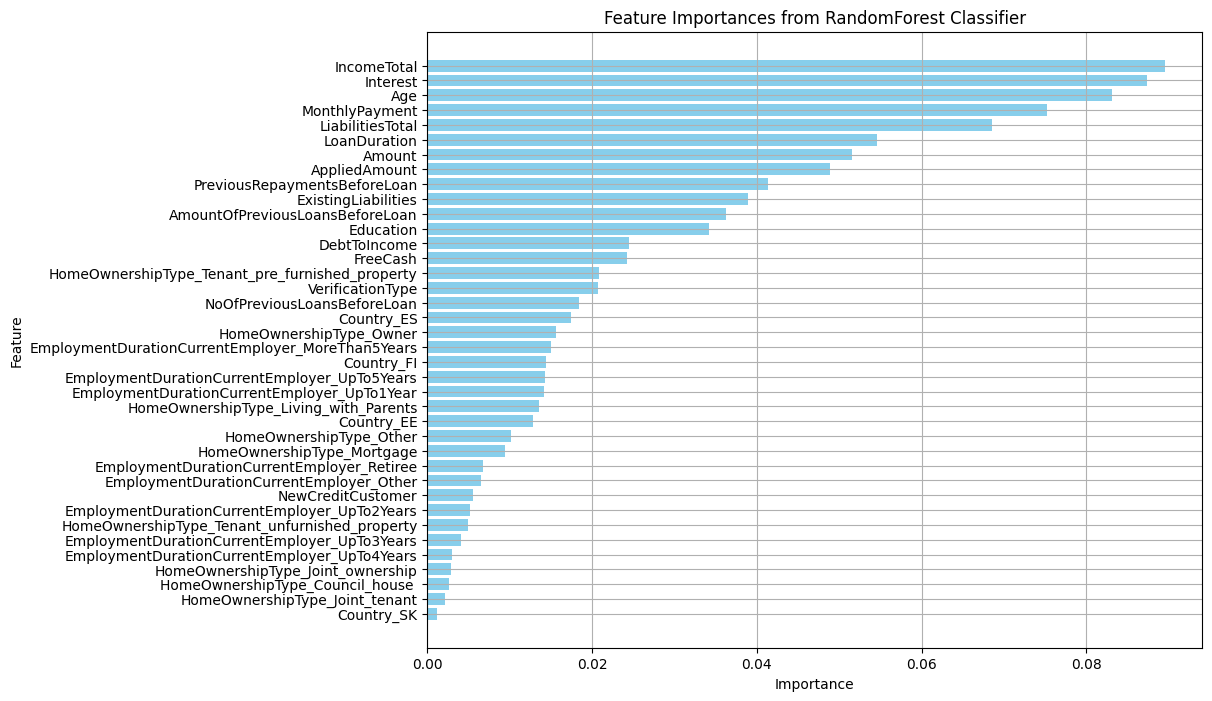

In [18]:
# Set up the matplotlib figure
plt.figure(figsize=(10, 8))  

# Create a bar plot of feature importances
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue') 

# Invert y-axis to have the most important feature at the top
plt.gca().invert_yaxis()

# Add labels and title for clarity
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForest Classifier')

# Optional: Add a grid
plt.grid(True)
plt.savefig('Feature Importances from RandomForest.png')
# Show the plot
plt.show()

In [19]:
# Subsetting the training and testing data using the selected top features
X_train_selected = X_train_resampled[top_features]
X_test_selected = X_test[top_features]

# Initialize your model (for example, CatBoostClassifier)
model = RandomForestClassifier(verbose=0, random_state=42)

# Train your model using the subset of training data containing only the top features
model.fit(X_train_selected, y_train_resampled)

# Evaluate your model on the subset of testing data containing only the top features
accuracy = model.score(X_test_selected, y_test)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.7054635081473367


In [20]:
#Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'n_estimators': randint(50, 150),  # Reduced upper limit for quicker evaluation
    'max_depth': [5, 10, 15, 20],      # Test a moderate range of depths
    'min_samples_split': randint(10, 50),
    'min_samples_leaf': randint(5, 20),
    'max_features': ['sqrt', 'log2'],   # More restrictive feature sampling
    'bootstrap': [True, False]
}


# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=30,  # Fewer iterations for quicker preliminary results
    cv=5,       # Reduced number of folds for speed
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1,
    return_train_score=True
)
# Fit RandomizedSearchCV on the resampled training data
random_search.fit(X_train_selected, y_train_resampled)

# Output the best parameters and the corresponding score
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 7, 'min_samples_split': 23, 'n_estimators': 130}
Best Score: 0.7481115770532689


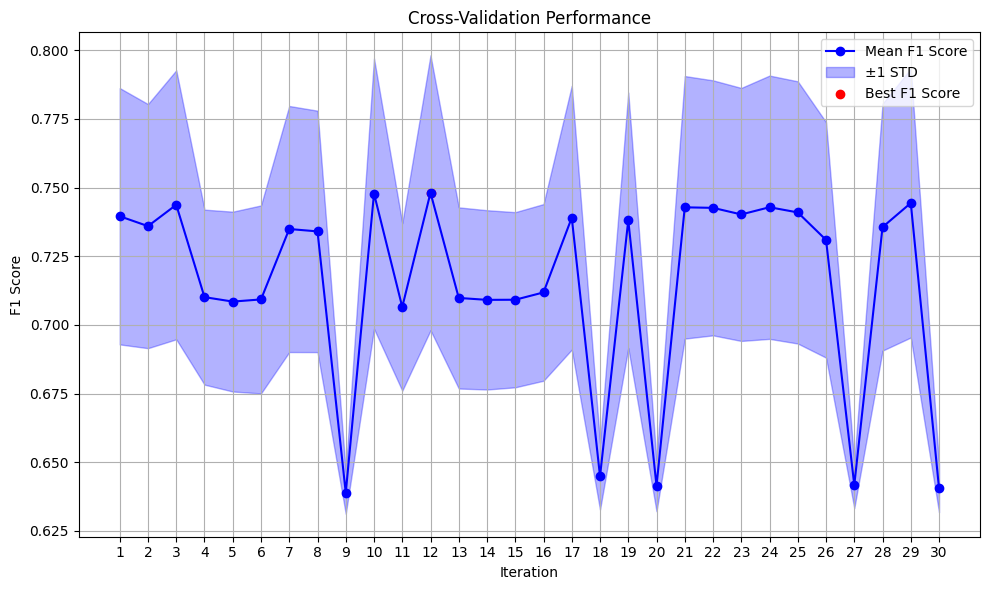

In [32]:
#cross validation
import matplotlib.pyplot as plt
import numpy as np

# Extract cross-validation results
cv_results = random_search.cv_results_

# Plot mean cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cv_results['mean_test_score']) + 1), cv_results['mean_test_score'], marker='o', label='Mean F1 Score', color='b')
plt.fill_between(range(1, len(cv_results['mean_test_score']) + 1),
                 cv_results['mean_test_score'] - cv_results['std_test_score'],
                 cv_results['mean_test_score'] + cv_results['std_test_score'],
                 alpha=0.3, color='b', label='±1 STD')

# Highlight the best performing point
best_index = np.argmax(cv_results['mean_test_score'])
plt.scatter(best_index + 1, cv_results['mean_test_score'][best_index], marker='o', color='r', label='Best F1 Score')

plt.title('Cross-Validation Performance')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.xticks(range(1, len(cv_results['mean_test_score']) + 1))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Cross-Validation Performance.png')
plt.show()

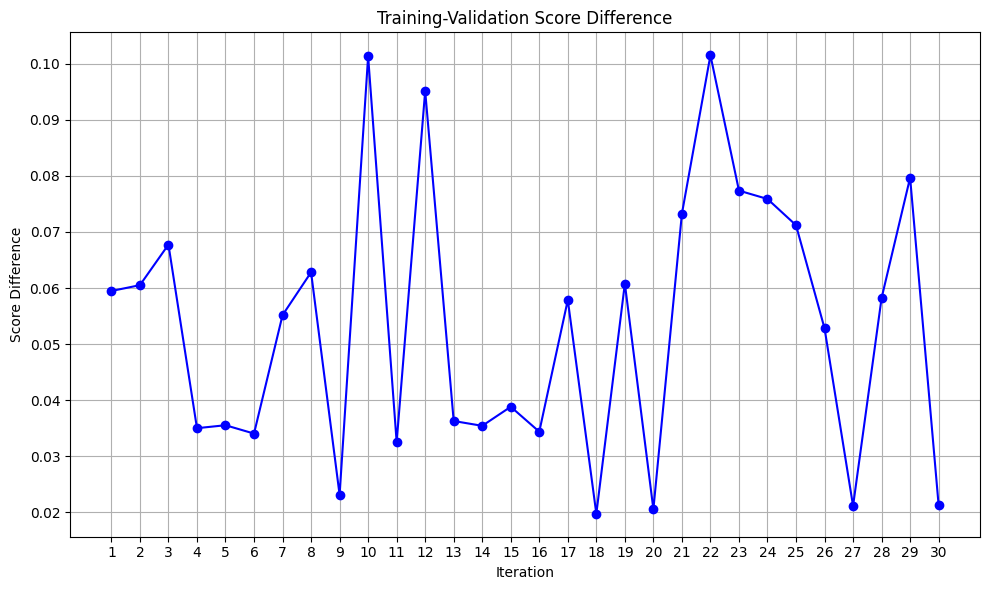

In [33]:
# Extract cross-validation results
train_scores = cv_results['mean_train_score']
test_scores = cv_results['mean_test_score']

# Calculate the difference between training and validation scores
score_diffs = train_scores - test_scores

# Plot the difference
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(score_diffs) + 1), score_diffs, marker='o', color='b')
plt.title('Training-Validation Score Difference')
plt.xlabel('Iteration')
plt.ylabel('Score Difference')
plt.xticks(range(1, len(score_diffs) + 1))
plt.grid(True)
plt.tight_layout()
plt.savefig('Training-Validation Score Difference.png')
plt.show()

In [23]:
# Evaluation on the test set
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_selected)
print("Test Set Accuracy:", accuracy_score(y_test, y_pred))
print("Test Set F1 Score:", f1_score(y_test, y_pred))

Test Set Accuracy: 0.7048245013464787
Test Set F1 Score: 0.7665595783850124


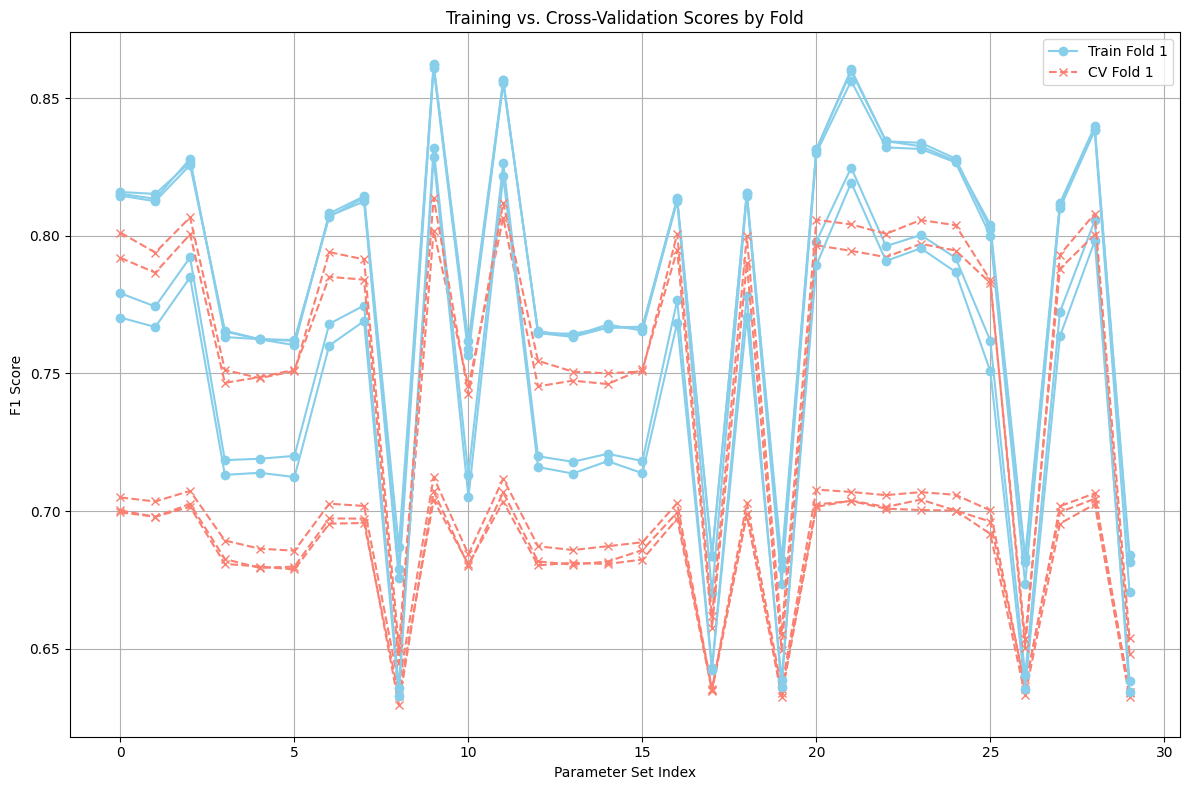

Average Training Scores:  0.7687352449816554
Average CV Scores:  0.7154405210475943


In [24]:
#check stability across folds
import matplotlib.pyplot as plt
import numpy as np

# Access cv_results from RandomizedSearchCV
cv_results = random_search.cv_results_

# Define parameter indices for easier navigation
params = np.arange(len(cv_results['mean_test_score']))

# Initialize figures for plotting
plt.figure(figsize=(12, 8))

# Iterate over each fold to plot
for i in range(5):  # Assuming 5-fold CV as specified in your setup
    train_scores = cv_results[f'split{i}_train_score']
    test_scores = cv_results[f'split{i}_test_score']

    # Plot training and test scores
    plt.plot(params, train_scores, marker='o', linestyle='-', label=f'Train Fold {i+1}' if i == 0 else None, color='skyblue')
    plt.plot(params, test_scores, marker='x', linestyle='--', label=f'CV Fold {i+1}' if i == 0 else None, color='salmon')

# Enhancing the plot
plt.title('Training vs. Cross-Validation Scores by Fold')
plt.xlabel('Parameter Set Index')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

# Calculating and printing average scores across all folds for a summary
mean_train_scores = np.mean([cv_results[f'split{i}_train_score'] for i in range(5)], axis=0)
mean_test_scores = np.mean([cv_results[f'split{i}_test_score'] for i in range(5)], axis=0)
print("Average Training Scores: ", np.mean(mean_train_scores))
print("Average CV Scores: ", np.mean(mean_test_scores))

In [25]:
# Assuming best_rf is your optimized model from RandomizedSearchCV
y_train_pred = best_rf.predict(X_train_selected)
y_test_pred = best_rf.predict(X_test_selected)

# Probability scores for ROC-AUC
y_train_proba = best_rf.predict_proba(X_train_selected)[:, 1]
y_test_proba = best_rf.predict_proba(X_test_selected)[:, 1]

In [26]:
# Training Metrics
accuracy_train = accuracy_score(y_train_resampled, y_train_pred)
precision_train = precision_score(y_train_resampled, y_train_pred)
recall_train = recall_score(y_train_resampled, y_train_pred)
roc_auc_train = roc_auc_score(y_train_resampled, y_train_proba)
f1_train = f1_score(y_train_resampled, y_train_pred)

# Test Metrics
accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
roc_auc_test = roc_auc_score(y_test, y_test_proba)
f1_test = f1_score(y_test, y_test_pred)

# Print Metrics
print("Training Metrics:")
print(f"Accuracy: {accuracy_train:.4f}, Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train:.4f}, ROC-AUC: {roc_auc_train:.4f}")
print("Test Metrics:")
print(f"Accuracy: {accuracy_test:.4f}, Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test:.4f}, ROC-AUC: {roc_auc_test:.4f}")
print("classification report:", classification_report(y_test, y_test_pred))


Training Metrics:
Accuracy: 0.8366, Precision: 0.7999, Recall: 0.8869, F1 Score: 0.8412, ROC-AUC: 0.9253
Test Metrics:
Accuracy: 0.7048, Precision: 0.7282, Recall: 0.8092, F1 Score: 0.7666, ROC-AUC: 0.7473
classification report:               precision    recall  f1-score   support

           0       0.66      0.55      0.60      8788
           1       0.73      0.81      0.77     13121

    accuracy                           0.70     21909
   macro avg       0.69      0.68      0.68     21909
weighted avg       0.70      0.70      0.70     21909



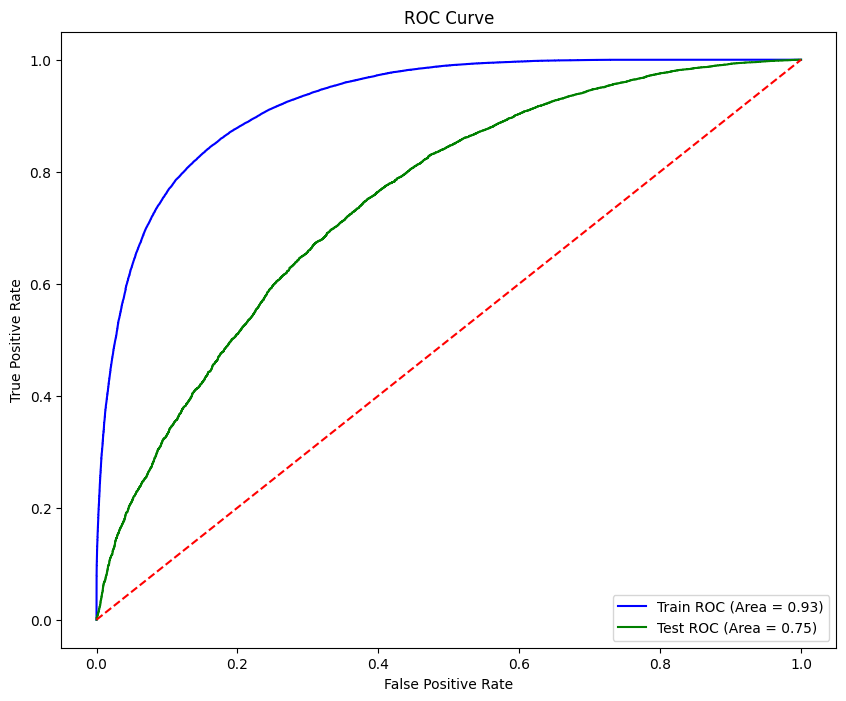

In [34]:
# Compute ROC curve data
fpr_train, tpr_train, _ = roc_curve(y_train_resampled, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plotting the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_train, tpr_train, label=f'Train ROC (Area = {roc_auc_train:.2f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Test ROC (Area = {roc_auc_test:.2f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('ROC Curve train and test.png')
plt.show()

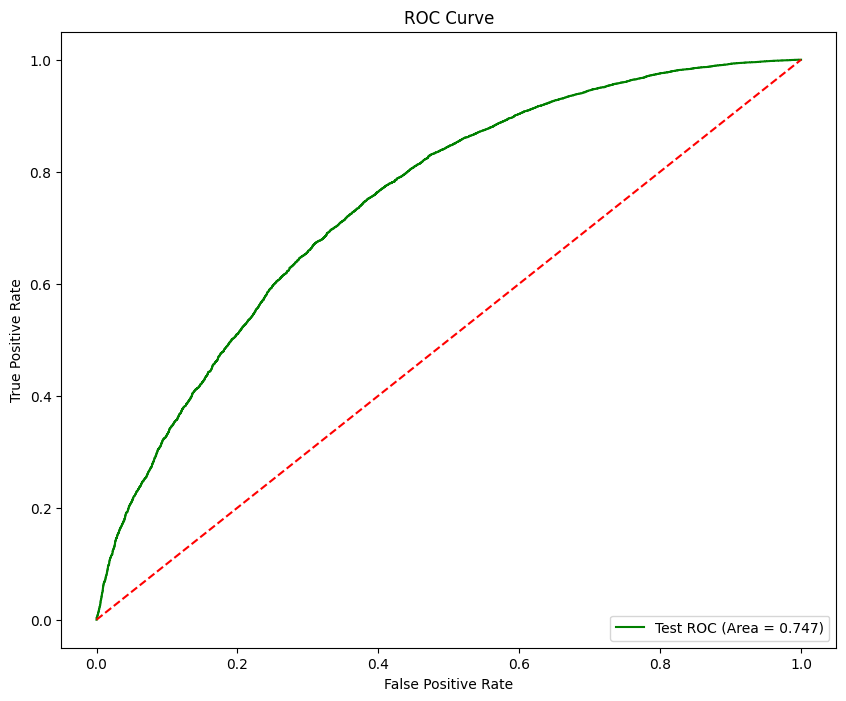

In [35]:
# Compute ROC curve data

fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

# Plotting the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr_test, tpr_test, label=f'Test ROC (Area = {roc_auc_test:.3f})', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='red')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig('ROC CURVE.png')
plt.show()

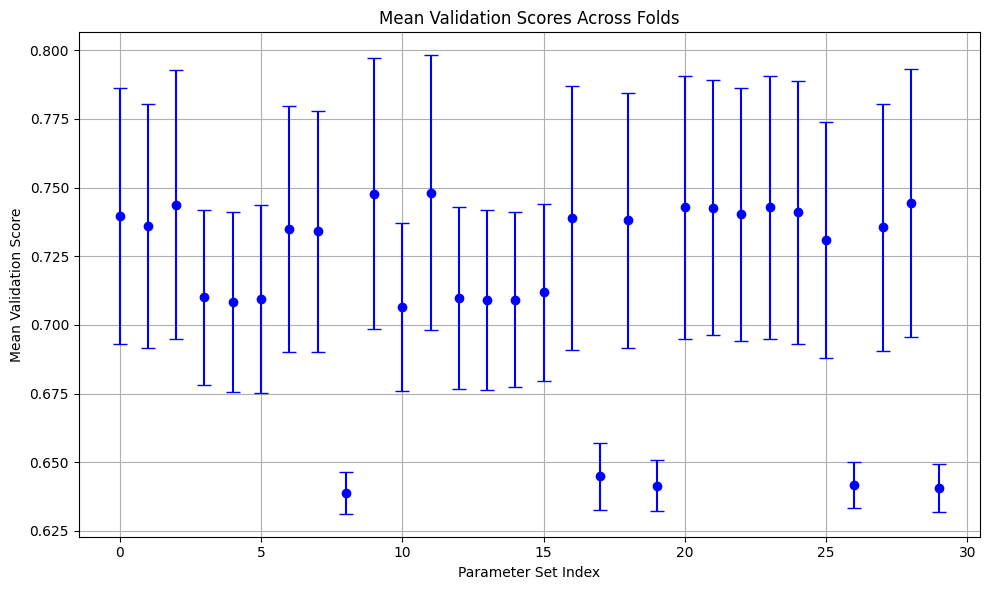

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Access cv_results from RandomizedSearchCV
cv_results = random_search.cv_results_

# Extract mean and standard deviation of validation scores across folds
mean_val_scores = cv_results['mean_test_score']
std_val_scores = cv_results['std_test_score']

# Plot mean validation scores with error bars representing standard deviation
plt.figure(figsize=(10, 6))
plt.errorbar(np.arange(len(mean_val_scores)), mean_val_scores, yerr=std_val_scores, fmt='o', color='b', capsize=5)
plt.title('Mean Validation Scores Across Folds')
plt.xlabel('Parameter Set Index')
plt.ylabel('Mean Validation Score')
plt.grid(True)
plt.tight_layout()
plt.show()

In [29]:
# Classification report
report_train = classification_report(y_train_resampled, y_train_pred)
report_test = classification_report(y_test, y_test_pred)

print("\nClassification Report for Training Set:")
print(report_train)

print("Classification Report for Test Set:")
print(report_test)


Classification Report for Training Set:
              precision    recall  f1-score   support

           0       0.88      0.79      0.83     55134
           1       0.80      0.89      0.84     52483

    accuracy                           0.84    107617
   macro avg       0.84      0.84      0.84    107617
weighted avg       0.84      0.84      0.84    107617

Classification Report for Test Set:
              precision    recall  f1-score   support

           0       0.66      0.55      0.60      8788
           1       0.73      0.81      0.77     13121

    accuracy                           0.70     21909
   macro avg       0.69      0.68      0.68     21909
weighted avg       0.70      0.70      0.70     21909



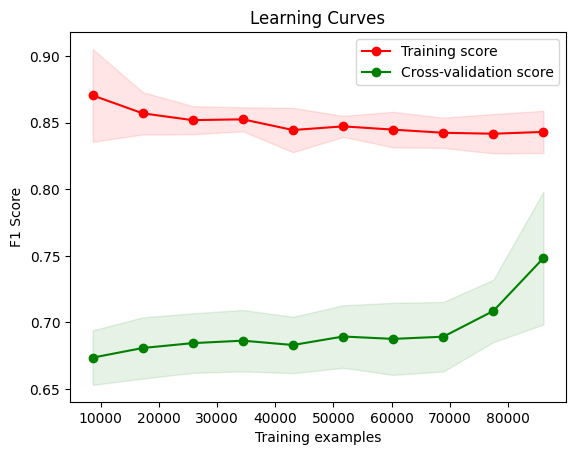

In [30]:
#Learning curve
from sklearn.model_selection import learning_curve

# Corrected to use resampled data for generating learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train_selected, y_train_resampled, cv=5, scoring='f1',
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curves
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, color='g', alpha=0.1)

plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('F1 Score')
plt.legend(loc='best')
plt.show()

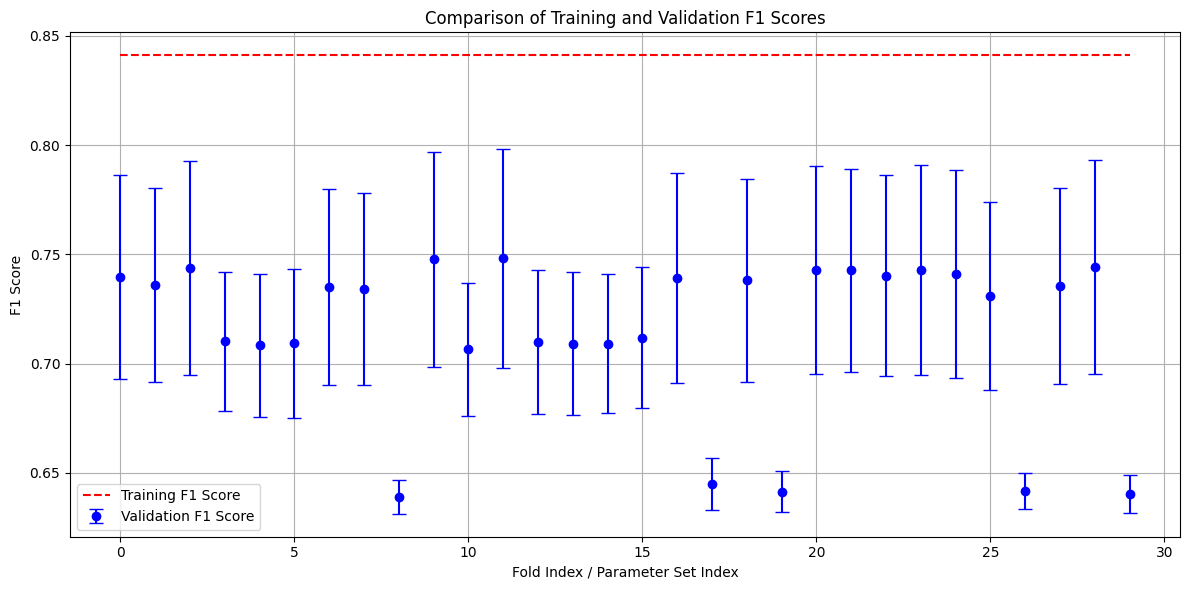

In [31]:
# Access cv_results from RandomizedSearchCV for validation scores
cv_results = random_search.cv_results_
mean_val_scores = cv_results['mean_test_score'] 
std_val_scores = cv_results['std_test_score']

# Your training F1 score
training_f1_score = f1_train  

# Create an array of the training score repeated for comparison
training_scores_repeated = np.full(len(mean_val_scores), training_f1_score)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(training_scores_repeated, label='Training F1 Score', color='red', linestyle='--')
plt.errorbar(np.arange(len(mean_val_scores)), mean_val_scores, yerr=std_val_scores, fmt='o', label='Validation F1 Score', color='blue', capsize=5)
plt.title('Comparison of Training and Validation F1 Scores')
plt.xlabel('Fold Index / Parameter Set Index')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

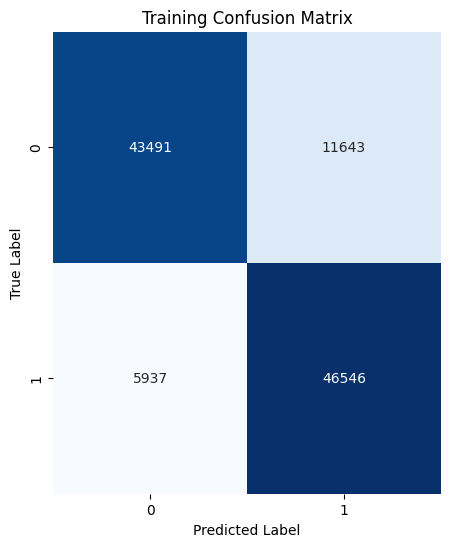

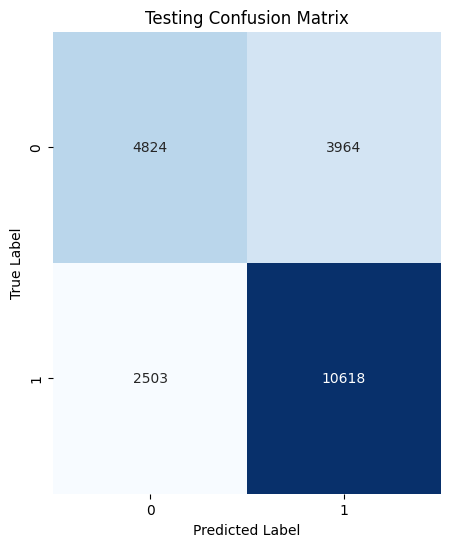

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Calculate confusion matrices
cm_train = confusion_matrix(y_train_resampled, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, title='Confusion Matrix', save_path=None):
    plt.figure(figsize=(5, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    if save_path:
        plt.savefig(save_path, bbox_inches='tight') 
    plt.show()

# Define file paths for saving figures
train_cm_save_path = 'training_confusion_matrix.png'
test_cm_save_path = 'testing_confusion_matrix.png'

# Plot confusion matrices and save figures
plot_confusion_matrix(cm_train, title='Training Confusion Matrix', save_path=train_cm_save_path)
plot_confusion_matrix(cm_test, title='Testing Confusion Matrix', save_path=test_cm_save_path)